## Research and cross validation

In [5]:
import os
import sys
from copy import deepcopy
from itertools import combinations
sys.path.insert(0, os.path.join('..'))

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from radial.batchflow import Dataset, FilesIndex, Pipeline, R, B, V, C
from radial.batchflow.models.tf import ResNet, ResNeXt18

from radial.batchflow.research import Research, Option
from radial.batchflow.research.research import Executable

from radial.core import RadialBatch
from radial.core.pipelines import create_preprocess_pipeline, create_train_pipeline

from research_utils import *
plt.style.use('ggplot')
%matplotlib inline

## Подготовка данных
если хотите обучать пайплайны по кросс валидации, напишите количество бинов в `cross_val` иначе будет происходить стандартное разделение на train/test.

In [2]:
cross_val = 3
path = './data/*'

dataset = create_datasets(path, RadialBatch, cross_val)

# Создание пайплайнов
Напиши сюда свой конфиг и свои пайпалйны.

In [8]:
N_SAMPLES = 100

model_config = {
    'inputs': dict(points=dict(shape=(N_SAMPLES, 2)),
                   targets=dict(name='target', shape=1)),
    'initial_block/inputs': 'points',
    'head': dict(layout='f',
                 units=1),
    'body/num_blocks': [1, 1, 1],
    'body/filters': C('body_filters'),
    'initial_block/filters': C('start_filters'),
    'loss': 'mse',
    'optimizer': 'Adam'
}

In [9]:
B_SIZE = 50
# тут создаем пайплайны для трейна и теста ресерча, без загрузки данных.
# NOTE: не забудте добавить run с параметром lazy=True!

prep_pipeline = create_preprocess_pipeline(N_SAMPLES, np.random.random)
train_pipeline = create_train_pipeline(C('model'), model_config, prep_pipeline).run(B_SIZE, n_epochs=None, drop_last=True, lazy=True)

test_pipeline = prep_pipeline + (Pipeline()
                        .init_variable('predictions', init_on_each_run=list)
                        .init_variable('targets', init_on_each_run=list)
                        .import_model('model', C('import_from'))
                        .predict_model('model', fetches='predictions',
                                                feed_dict={'points': B('points'),
                                                           'targets': B('target')},
                                        save_to=B('predictions'), mode='w')
                        .denormalize_component(src=['predictions', 'target'], 
                                               dst=['denorm_predictions', 'denorm_target'],
                                               src_range=['derivative_q', 'derivative_q'])
                        .update_variable('predictions', B('denorm_predictions'), mode='e')
                        .update_variable('targets', B('denorm_target'), mode='e')
                        .run(B_SIZE, n_epochs=1, drop_last=True, lazy=True)
)

# Метрики
По дефолту будем считать метрики mape и Котежеков-like

In [17]:
def get_mape(iteration, experiment, pipeline):
    """ Calculate mean absolute percentage error."""
    _ = iteration
    pipeline = experiment[pipeline].pipeline
    y_pred = np.array(pipeline.get_variable('predictions')).reshape(-1)
    y_true = np.array(pipeline.get_variable('targets')).reshape(-1)
    return np.mean(np.abs(y_true-y_pred)/y_true)

def get_mape30(iteration, experiment, pipeline):
    """ Calculate percentage of mean absolute percentage error which less than 30%."""
    _ = iteration
    pipeline = experiment[pipeline].pipeline
    y_pred = np.array(pipeline.get_variable('predictions')).reshape(-1)
    y_true = np.array(pipeline.get_variable('targets')).reshape(-1)
    ape = np.abs(y_true-y_pred)/y_true
    return np.mean(ape < 0.3)*100

def get_logmape30(iteration, experiment, pipeline):
    """ Calculate log percentage of mean absolute percentage error which less than 30%."""
    _ = iteration
    pipeline = experiment[pipeline].pipeline
    y_pred = np.log10(np.array(pipeline.get_variable('predictions')).reshape(-1))
    y_true = np.log10(np.array(pipeline.get_variable('targets')).reshape(-1))
    ape = np.abs(y_true-y_pred)/y_true
    return np.mean(ape < 0.3)*100

# сохраним обученные модели
def save_model(iteration, experiment, pipeline, model_name, path='./'):
    """ Save model to a path."""
    path = os.path.join(path, experiment[pipeline].config.alias(as_string=True) + '_' + str(iteration))
    pipeline = experiment[pipeline].pipeline
    pipeline.save_model(model_name, path)
    return

def get_ape(iteration, experiment, pipeline):
    """ Calculate percentage of absolute percentage error."""
    _ = iteration
    pipeline = experiment[pipeline].pipeline
    y_pred = np.array(pipeline.get_variable('predictions')).reshape(-1)
    y_true = np.array(pipeline.get_variable('targets')).reshape(-1)
    return np.abs(y_true-y_pred)/y_true


def get_logape(iteration, experiment, pipeline):
    """ Calculate percentage of absolute percentage error."""
    _ = iteration
    pipeline = experiment[pipeline].pipeline
    y_pred = np.log10(np.array(pipeline.get_variable('predictions')).reshape(-1))
    y_true = np.log10(np.array(pipeline.get_variable('targets')).reshape(-1))
    return np.abs(y_true-y_pred)/y_true

## Создание Research
Тут напиши свой объект research и набор параметров.

In [11]:
# измени на свои параметры
opts = Option('model', [ResNet]) \
       * Option('body_filters', [[4, 8, 16],
                                 [8, 16, 32]]) * Option('start_filters', [4, 8])

research = (Research()
            .pipeline(train_pipeline, variables='loss', name='train')
            .pipeline(test_pipeline, name='test', execute='%5',
                      run=True, import_from='train')
            .grid(opts)
            .function(get_mape, returns='metrics', name='test_mape',
                      execute='%5', pipeline='test')
            .function(get_mape30, returns='metrics', name='test_mape30',
                      execute='%5', pipeline='test')
            .function(get_logmape30, returns='metrics', name='test_log30',
                     execute='%5', pipeline='test')
            .function(get_logape, returns='metrics', name='test_ape',
                     execute=-1, pipeline='test')
            .function(save_model, execute=-1, pipeline='train',
                      model_name='model', path='saved_models/')
)

Запуск ресерча происходит при помощи функции `execute_research_with_cv`. Скорее всего тебе не придется менять никакие параметры кроме `n_reps` и `n_iters`. 

In [ ]:
res = execute_research_with_cv(train_pipeline, test_pipeline, research, dataset, n_reps=3, n_iters=1500, cross_val=cross_val, dir_name='research_resnets_3')

number of bins:  3
Research ./research_resnets_3/research_cv_0 is starting...


  0%|          | 0/18000 [00:00<?, ?it/s]

Distributor has 12 jobs with 1500 iterations. Totally: 18000


  4%|▎         | 630/18000 [04:07<1:53:43,  2.55it/s]

## Обработка результатов
С помощью функций `draw_history` можно рисовать графики лосса и метрик. С помощью функции `draw_histogram` можно нарисовать гисторгамму mape.

## Результаты с порядком каналов (SHAPE, 2)
1) Не логорифмированные

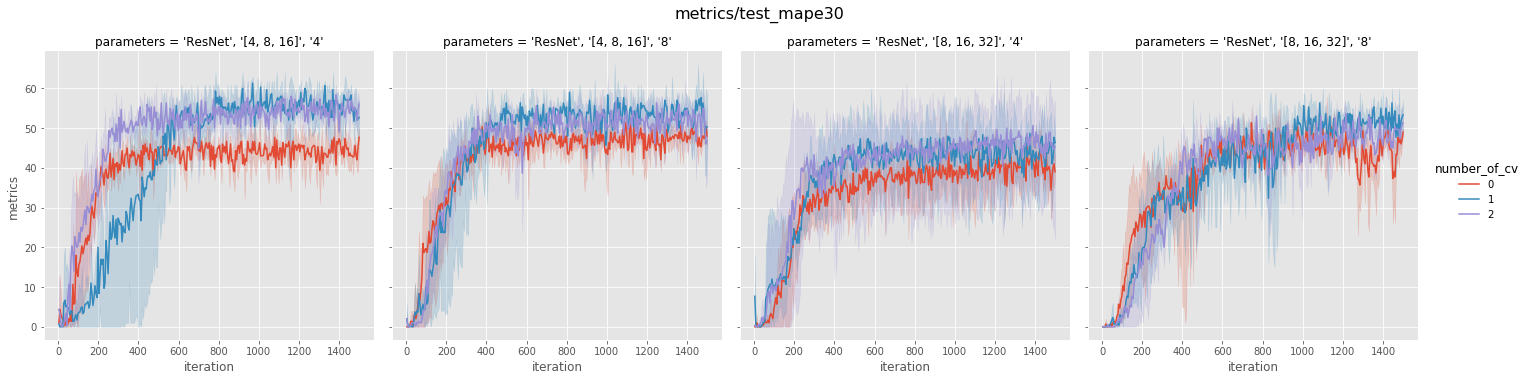

In [15]:
draw_dict = dict(model=['ResNet'])
draw_history(research='research_resnets_3/', names=['test_mape30'], types_var=['metrics'], cross_val=cross_val, aggr=False, iter_start=1, draw_dict=draw_dict)

2) Логорифмированные

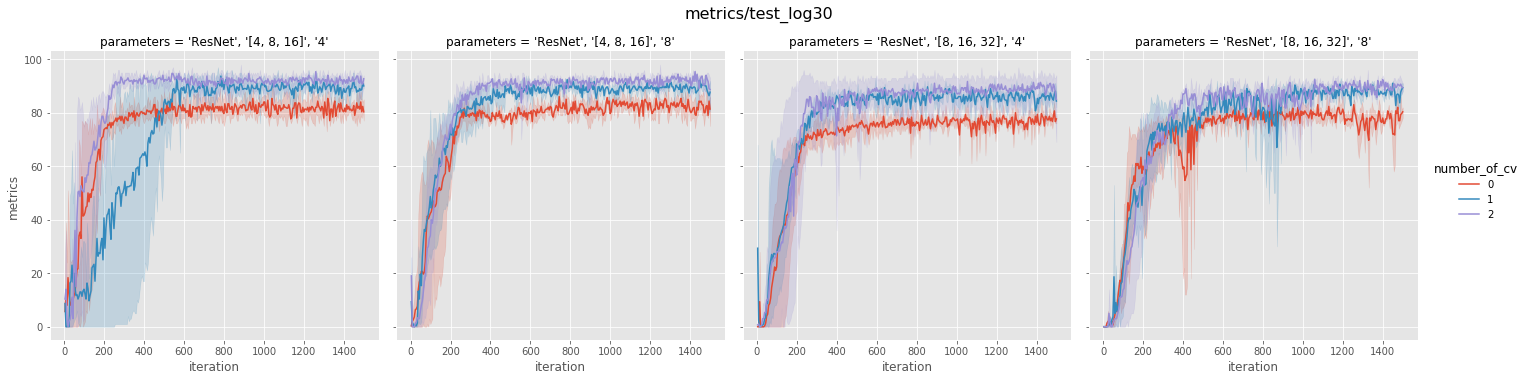

In [16]:
draw_dict = dict(model=['ResNet'])
draw_history(research='research_resnets_3/', names=['test_log30'], types_var=['metrics'], cross_val=cross_val, aggr=False, iter_start=1, draw_dict=draw_dict)

## Результаты с порядком каналов (2, SHAPE)
1) Не логорифмированные

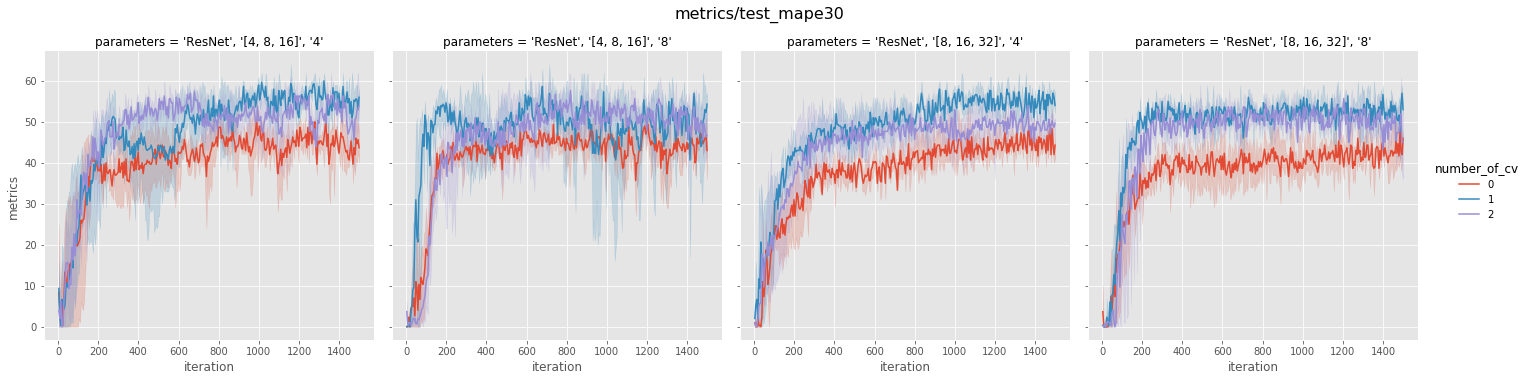

In [14]:
draw_dict = dict(model=['ResNet'])
draw_history(research='research_resnets_2/', names=['test_mape30'], types_var=['metrics'], cross_val=cross_val, aggr=False, iter_start=1, draw_dict=draw_dict)

2) Логорифмированные

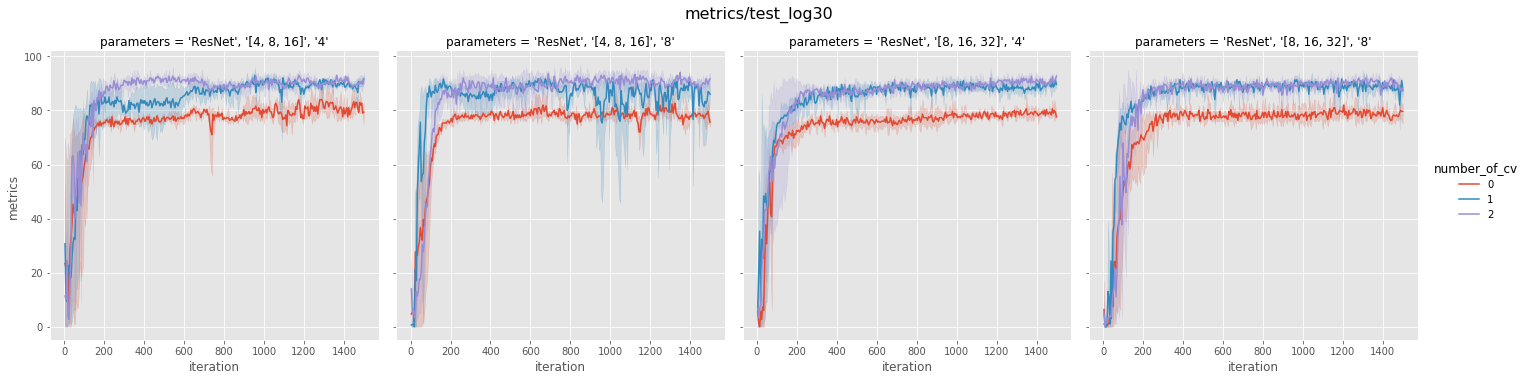

In [16]:
draw_dict = dict(model=['ResNet'])
draw_history(research='research_resnets_2/', names=['test_log30'], types_var=['metrics'], cross_val=cross_val, aggr=False, iter_start=1, draw_dict=draw_dict)

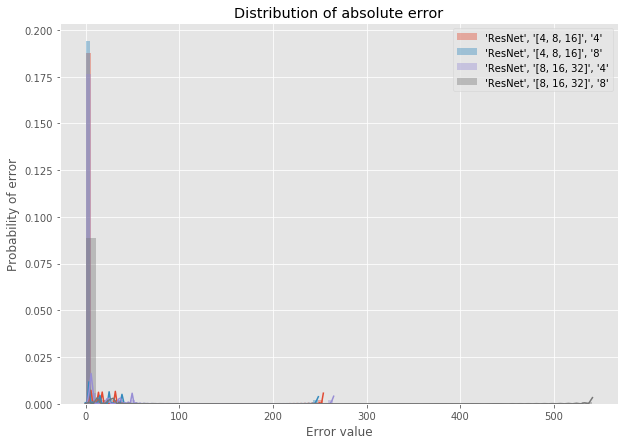

In [18]:
draw_dict = dict(model=['ResNet'])
draw_hisogram('research_resnets_3/', name='test_ape', type_var='metrics', cross_val=cross_val, draw_dict=draw_dict)